To not clutter the code too much, I have started a new notebook for the painting investigation/analysis.

In [1]:
%run ../scripts/notebook_settings.py
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")

In [2]:
meta_data_samples.loc[meta_data_samples.C_origin == "Cynocephalus, Western Tanzania"]

,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex,address,longitude,latitude,callset_index,C_origin
39,PD_0228,01MNM1300916,Knauf/Chuma/Roos,Papio,cynocephalus,"Mahale, Tanzania",M,"Mahale National Park, Kigoma, Western Zone, Ta...",29.883426,-6.203292,39,"Cynocephalus, Western Tanzania"
40,PD_0229,02MNM1300916,Knauf/Chuma/Roos,Papio,cynocephalus,"Mahale, Tanzania",M,"Mahale National Park, Kigoma, Western Zone, Ta...",29.883426,-6.203292,40,"Cynocephalus, Western Tanzania"
41,PD_0230,04MNM1300916,Knauf/Chuma/Roos,Papio,cynocephalus,"Mahale, Tanzania",M,"Mahale National Park, Kigoma, Western Zone, Ta...",29.883426,-6.203292,41,"Cynocephalus, Western Tanzania"
42,PD_0231,09MNM1011016,Knauf/Chuma/Roos,Papio,cynocephalus,"Mahale, Tanzania",M,"Mahale National Park, Kigoma, Western Zone, Ta...",29.883426,-6.203292,42,"Cynocephalus, Western Tanzania"
43,PD_0232,14MNF1041016,Knauf/Chuma/Roos,Papio,cynocephalus,"Mahale, Tanzania",F,"Mahale National Park, Kigoma, Western Zone, Ta...",29.883426,-6.203292,43,"Cynocephalus, Western Tanzania"
44,PD_0233,05KNM1121016,Knauf/Chuma/Roos,Papio,cynocephalus,"Katavi, Tanzania",M,"Katavi, Western Zone, Tanzania",30.927827,-6.301549,44,"Cynocephalus, Western Tanzania"
45,PD_0234,10KNM1131016,Knauf/Chuma/Roos,Papio,cynocephalus,"Katavi, Tanzania",M,"Katavi, Western Zone, Tanzania",30.927827,-6.301549,45,"Cynocephalus, Western Tanzania"
103,PD_0658,79 / 08MNM1011016,Knauf/Chuma/Roos,Papio,cynocephalus,"Mahale, Tanzania",M,"Mahale National Park, Kigoma, Western Zone, Ta...",29.883426,-6.203292,103,"Cynocephalus, Western Tanzania"
104,PD_0659,81 / 13MNF1031016,Knauf/Chuma/Roos,Papio,cynocephalus,"Mahale, Tanzania",F,"Mahale National Park, Kigoma, Western Zone, Ta...",29.883426,-6.203292,104,"Cynocephalus, Western Tanzania"
105,PD_0662,85 / 01UGF5101016,Knauf/Chuma/Roos,Papio,cynocephalus,"Issa Valley, Tanzania",F,"Tansania, Monduli, Arusha, Northern Zone, Tanz...",36.465300,-2.872690,105,"Cynocephalus, Western Tanzania"


In [3]:
#Functions to generate the stacked area plot df

#Should be easily extendable to multiple paintings by repeating the loop
def count_paint_windows(pop_dict, spot_df, window):
    end_pos = spot_df.end_pos.values[-1]
    pop_dict["window"] = list(range(end_pos//window+1))
    for window_number in range(end_pos//window+1):
        #Selecting the rows which are inside
        window_start = window*window_number
        window_end = window*(window_number+1)-1
        sub_df = spot_df.loc[(spot_df.end_pos >= window_start)
                    & (spot_df.pos < window_end)]
        total_paint = 0
        for i, row in sub_df.iterrows():
            #When the painting covers the whole window
            if len(sub_df) == 1:
                pop_dict[row["pop"]][window_number] += window
                total_paint += window
            #When the painting started before the window
            elif row.pos < window_start:
                pop_dict[row["pop"]][window_number] += row.end_pos-window_start
                total_paint += row.end_pos-window_start
            #When the painting ends after the window
            elif row.end_pos > window_end:
                pop_dict[row["pop"]][window_number] += window_end-row.pos
                total_paint += window_end-row.pos
            #When the painting is fully in the window
            else:
                pop_dict[row["pop"]][window_number] += row.paint_length
                total_paint += row.paint_length
    return pop_dict

def generate_spot_df(single_p_df, map_dict):
    single_p_df["pop"] = single_p_df["paint"].map(map_dict)
    shift_spots = (single_p_df["pop"] != single_p_df["pop"].shift())
    #df based on this subset
    spot_df = single_p_df.loc[shift_spots].copy()
    #Finding the start of the next painting, by removing the first pos and adding the last snp.
    #And then calculating the difference.
    spot_df["paint_length"] = (np.append(spot_df["pos"][1:].values, single_p_df.iloc[-1]["pos"])-spot_df["pos"].values)
    spot_df["end_pos"] = (np.append(spot_df["pos"][1:].values, single_p_df.iloc[-1]["pos"])-1)
    return spot_df

def create_paint_df_summary(paintfile, window, idfile):
    #various supplemental dataframes/lists
    end_pos = pos_list.values[-1]
    
    map_dict = {}
    for i, row in idfile.iterrows():
        map_dict[row.ID_index*2+1] = row["pop"]
        map_dict[row.ID_index*2+2] = row["pop"]

    df_l = []
    f = open(paintfile, "r")
    ad_lines = f.readlines()
    ind = ""
    for p_num in range(1, len(ad_lines)):
        l = ad_lines[p_num].strip().split(" ")
        if l[0] == "HAP":
            ind = l[2]
        else:
            pop_dict = {}
            for population in idfile.loc[idfile.inclusion==1]["pop"].unique():
                pop_dict[population] = [0]*(end_pos//window+1)
            paint_line = l[1:]
            single_p_df = pd.DataFrame(data={"pos": pos_list, "paint": paint_line})
            single_p_df = single_p_df.astype(int)
            spot_df = generate_spot_df(single_p_df, map_dict)
            sub_dict = count_paint_windows(pop_dict.copy(), spot_df, window)
            sub_df = pd.DataFrame(sub_dict)
            sub_df["individual"] = ind
            df_l.append(sub_df)
    all_df = pd.concat(df_l)
    all_df = all_df.set_index("window")
    return all_df

def create_paint_df_lengths(paintfile, window, idfile):
    #various supplemental dataframes/lists
    end_pos = pos_list.values[-1]
    
    map_dict = {}
    for i, row in idfile.iterrows():
        map_dict[row.ID_index*2+1] = row["pop"]
        map_dict[row.ID_index*2+2] = row["pop"]

    df_l = []
    f = open(paintfile, "r")
    ad_lines = f.readlines()
    ind = ""
    for p_num in range(1, len(ad_lines)):
        l = ad_lines[p_num].strip().split(" ")
        if l[0] == "HAP":
            ind = l[2]
        else:
            pop_dict = {}
            for population in idfile.loc[idfile.inclusion==1]["pop"].unique():
                pop_dict[population] = [0]*(end_pos//window+1)
            paint_line = l[1:]
            single_p_df = pd.DataFrame(data={"pos": pos_list, "paint": paint_line})
            single_p_df = single_p_df.astype(int)
            spot_df = generate_spot_df(single_p_df, map_dict)
            spot_df["individual"] = ind
            df_l.append(spot_df)
    all_df = pd.concat(df_l)
    return all_df

In [4]:
recomb_map_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/chr{}/chr{}.females.recombfile"
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster_females.ids"

In [5]:
#Constant files, the idfile and the recombination map
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
recomb_map = pd.read_csv(recomb_map_path.format("X", "X"), sep=" ")
pos_list = recomb_map["start.pos"]

In [6]:
chrom = "X"
recomb_map = pd.read_csv(recomb_map_path.format(chrom, chrom), sep=" ")
pos_list = recomb_map["start.pos"]
recomb_map_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/chr{}/chr{}.females.recombfile"
anubis_tanz_X = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/" \
                    "chr{}_8_cluster/anubis_tanzania_chr{}_8_cluster/chr{}.samples.out".format(chrom, chrom, chrom)
window = 100000
window_df = create_paint_df_summary(anubis_tanz_X, window, idfile)
length_df = create_paint_df_lengths(anubis_tanz_X, window, idfile)

In [31]:
sum_windows = window_df.groupby(level=0).sum()
anubis_paint = sum_windows["anubis_ethiopia"]
non_anubis_fraction = (sum_windows.sum(axis=1)-anubis_paint)/sum_windows.sum(axis=1)

In [32]:
non_anubis_fraction

window
0       0.501866
1       0.478087
2       0.320695
3       0.312097
4       0.373788
          ...   
1432    0.620527
1433    0.646541
1434    0.626788
1435    0.551450
1436    0.561494
Length: 1437, dtype: float64

<AxesSubplot:ylabel='Count'>

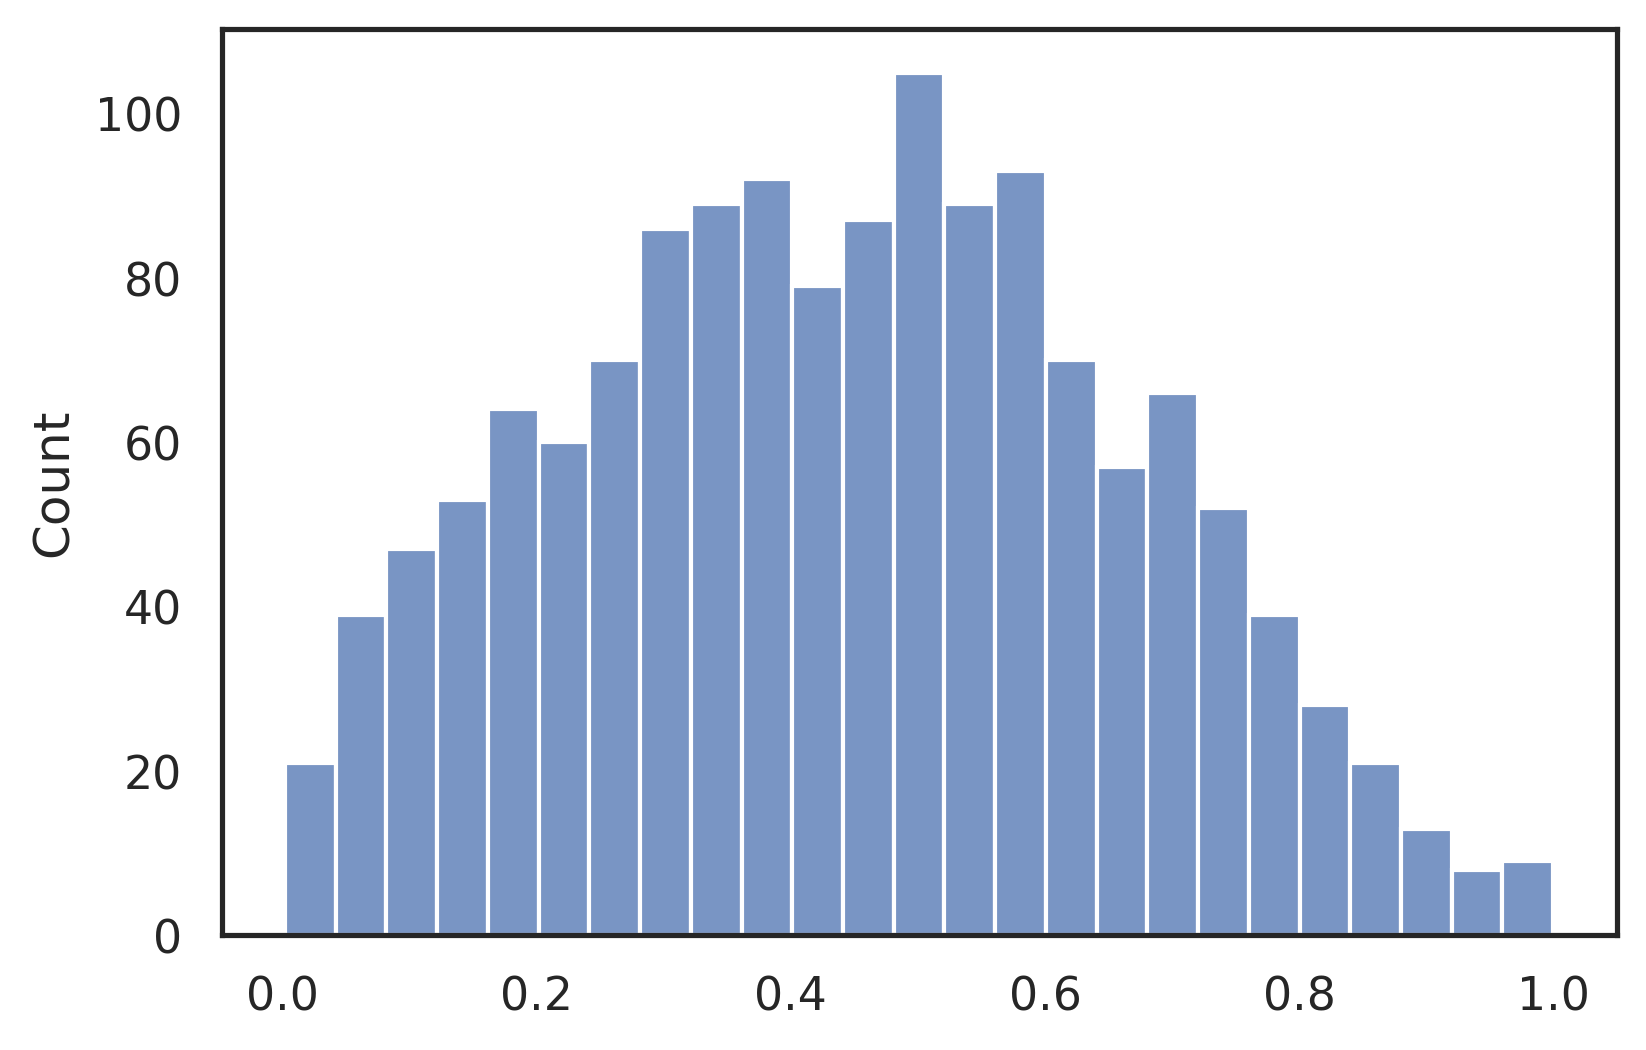

In [33]:
sns.histplot(non_anubis_fraction, bins=25)

In [36]:
chrom = "8"
recomb_map = pd.read_csv(recomb_map_path.format(chrom, chrom), sep=" ")
pos_list = recomb_map["start.pos"]
recomb_map_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/chr{}/chr{}.females.recombfile"
anubis_tanz_auto = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/" \
                    "chr{}_8_cluster/anubis_tanzania_chr{}_8_cluster/chr{}.samples.out".format(chrom, chrom, chrom)
window = 100000
window_df_auto = create_paint_df_summary(anubis_tanz_auto, window, idfile)
length_df_auto = create_paint_df_lengths(anubis_tanz_auto, window, idfile)

NameError: name 'anubis_anubis_tanz_autotanz_8' is not defined

In [37]:
sum_windows = window_df_auto.groupby(level=0).sum()
anubis_paint = sum_windows["anubis_ethiopia"]
non_anubis_fraction = (sum_windows.sum(axis=1)-anubis_paint)/sum_windows.sum(axis=1)

<AxesSubplot:ylabel='Count'>

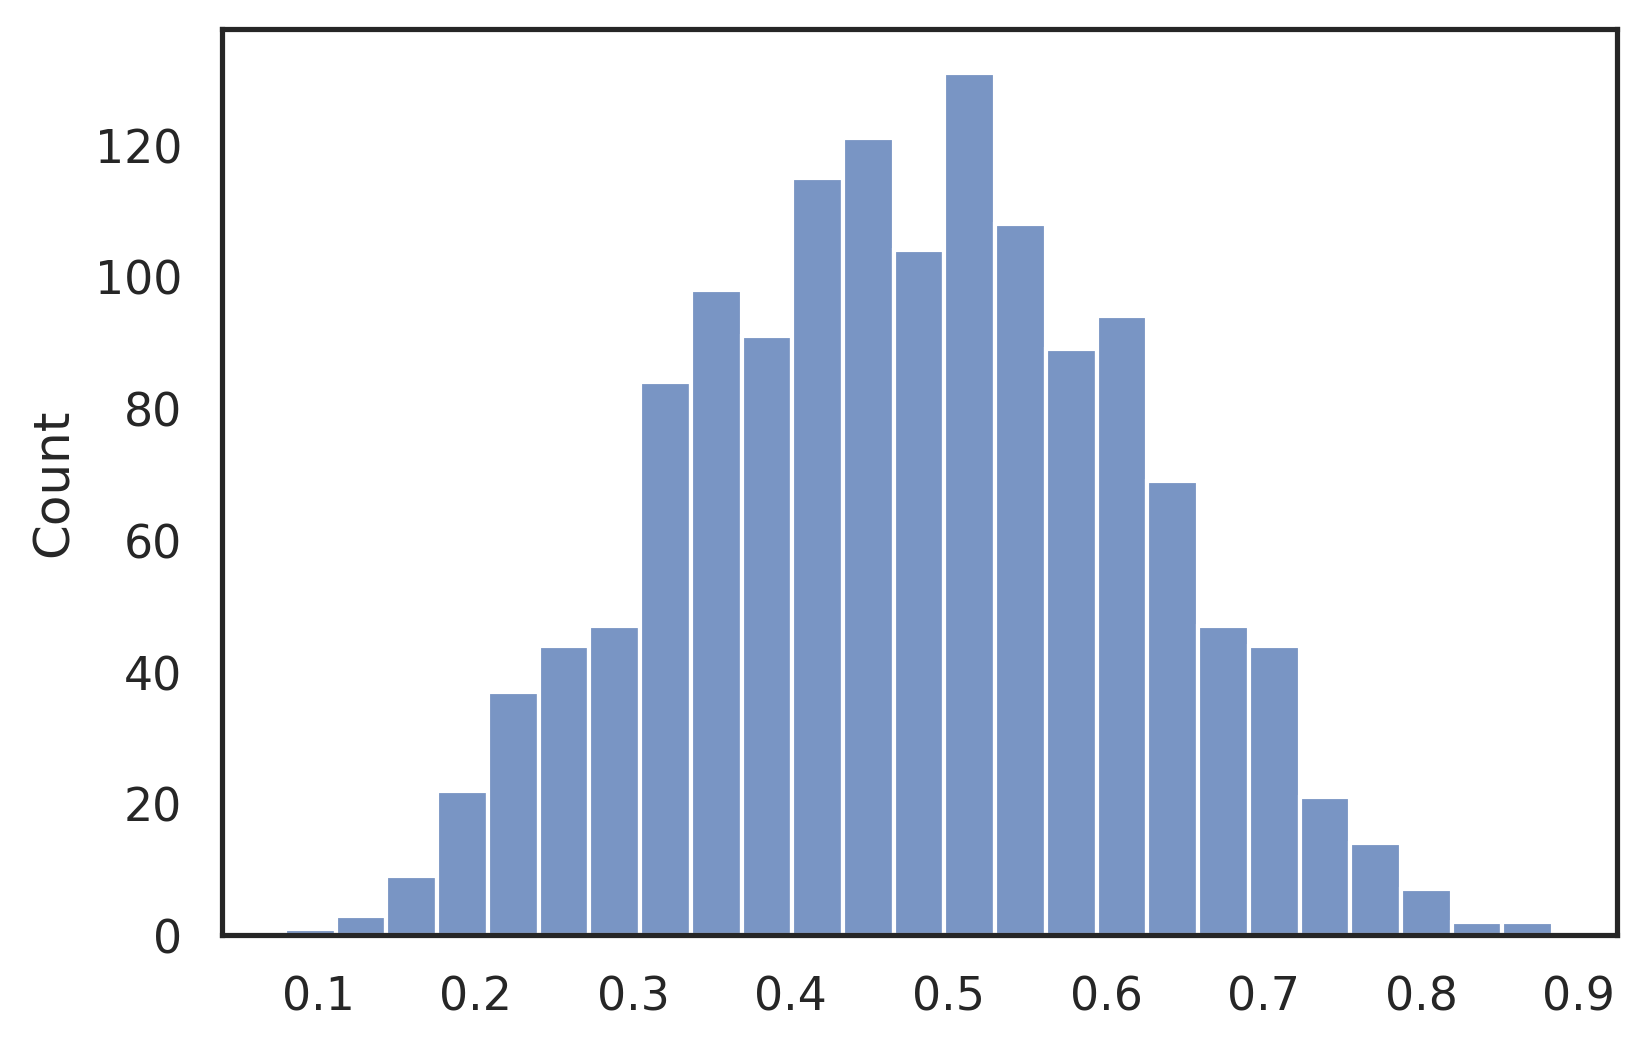

In [38]:
sns.histplot(non_anubis_fraction, bins=25)

[None, Text(0.5, 1.0, 'All West Cyno')]

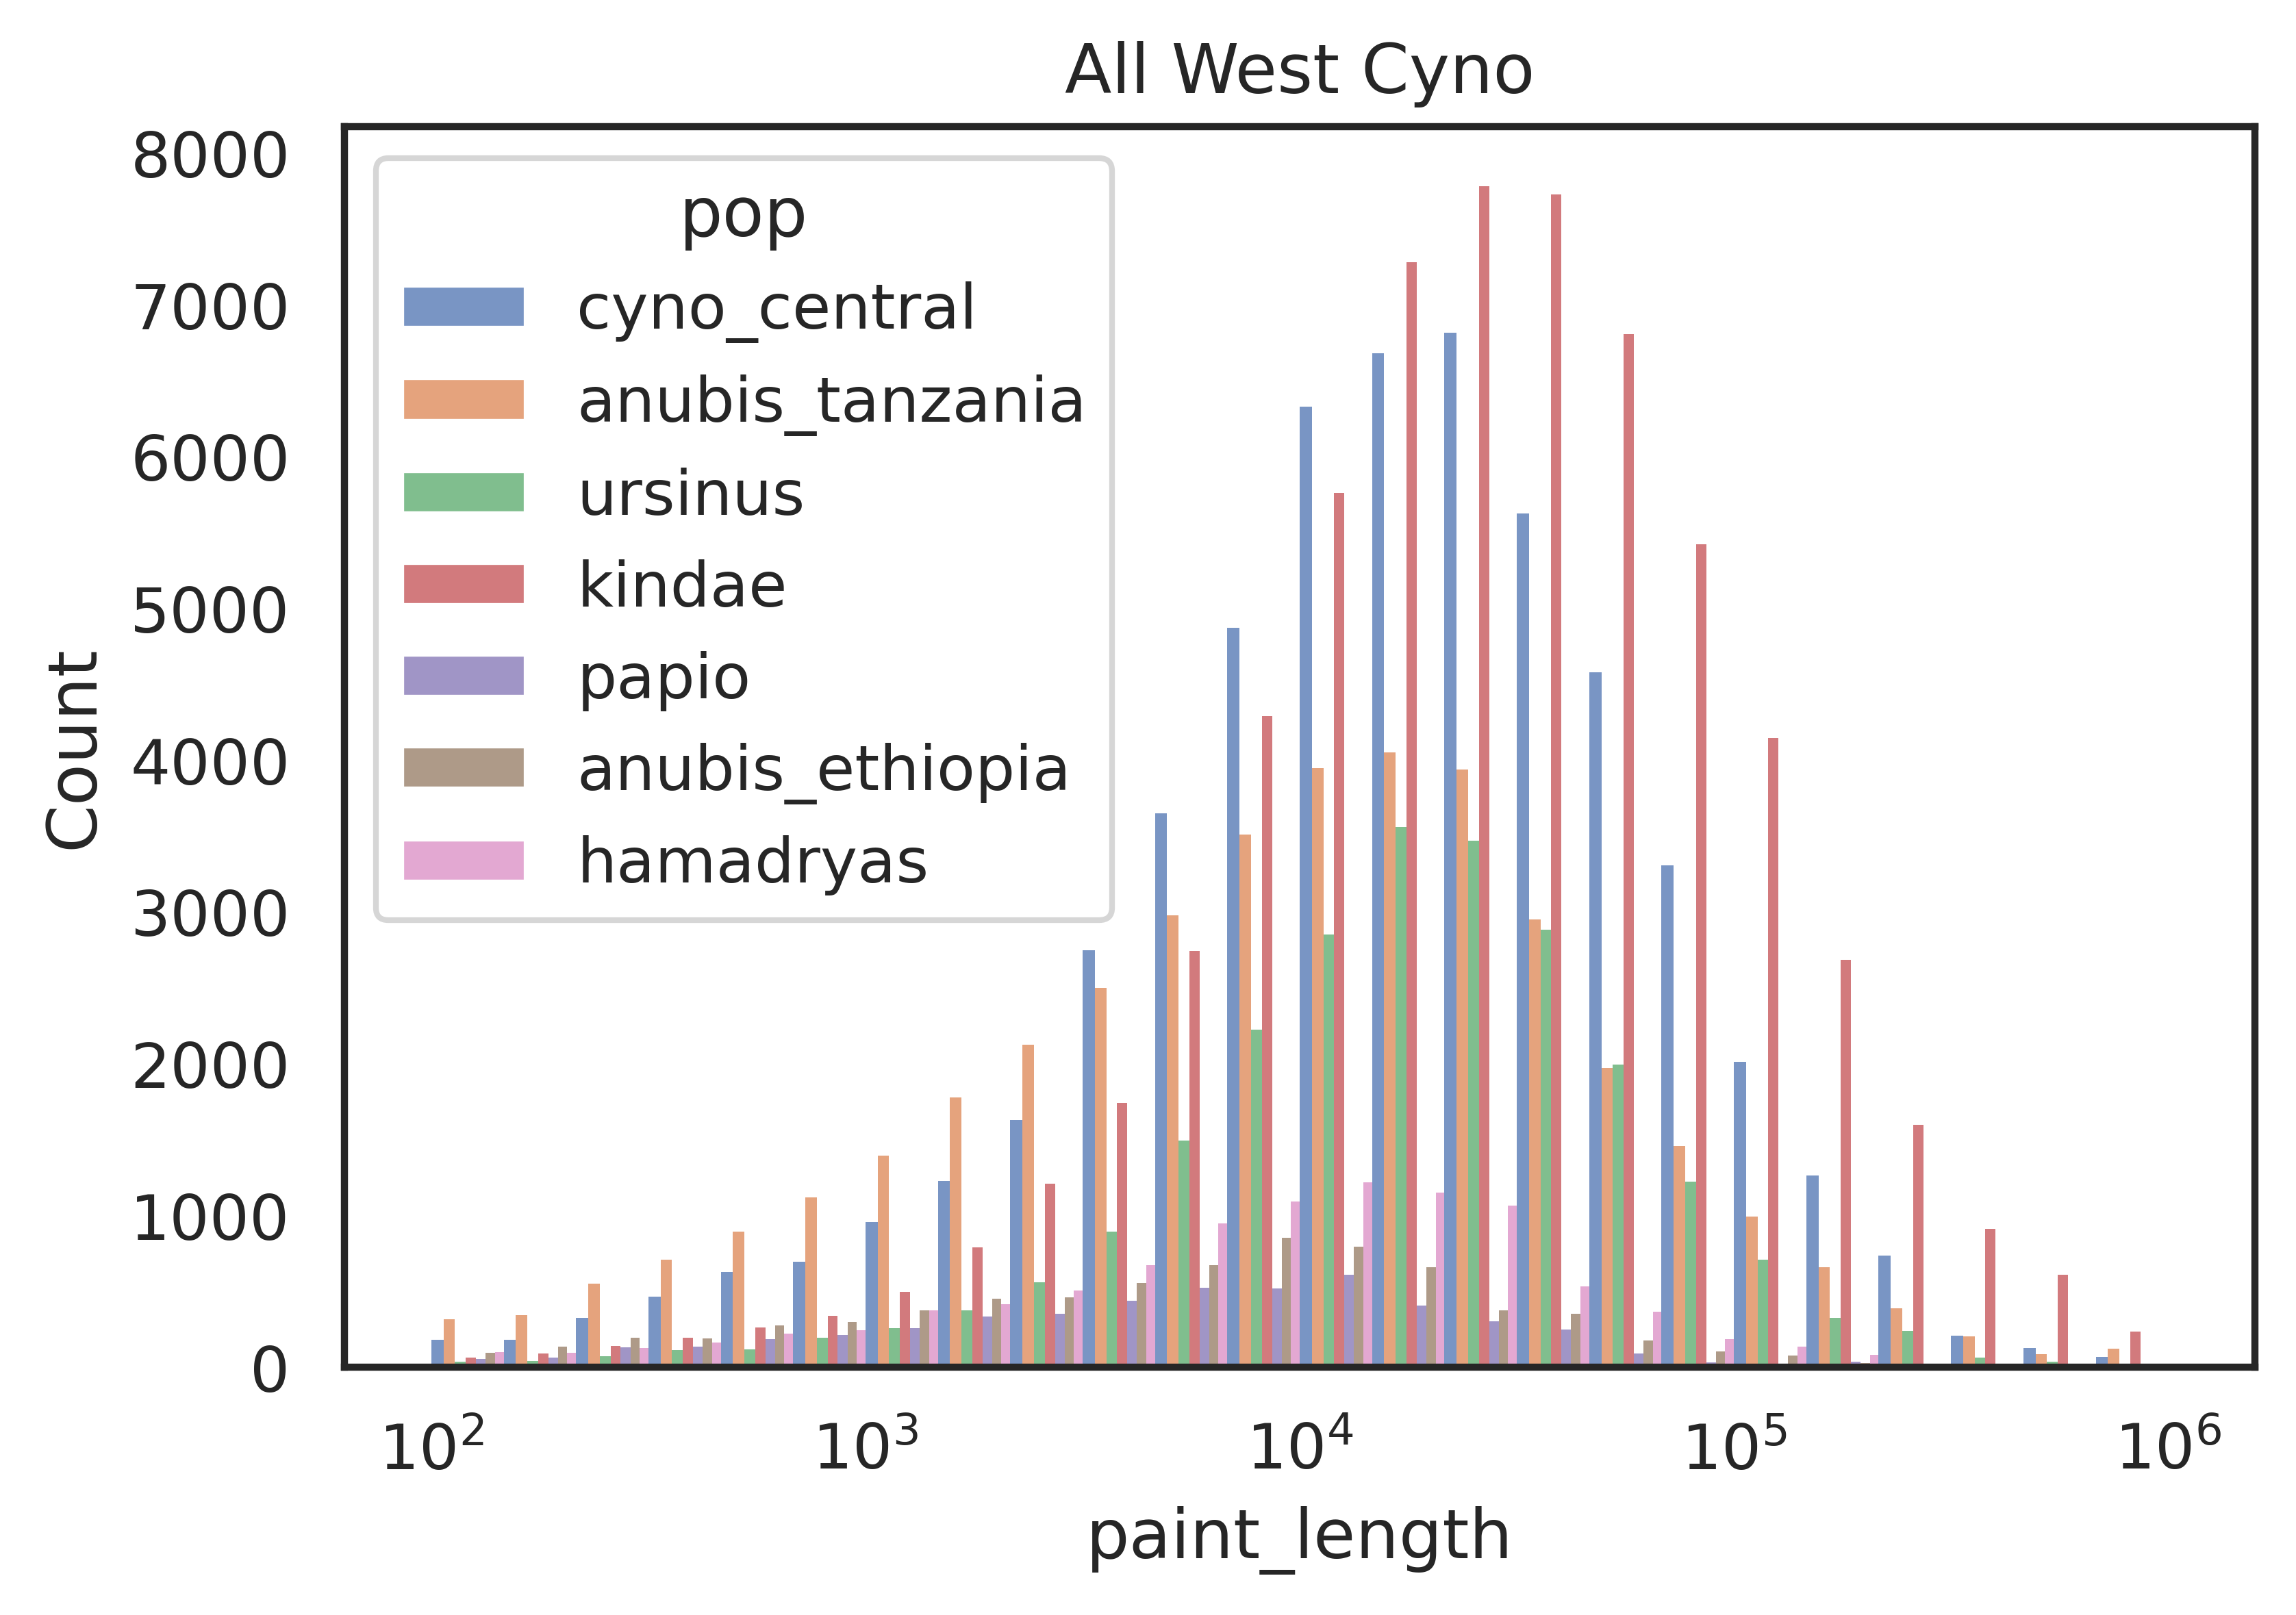

In [60]:
g = sns.histplot(length_df, x="paint_length", hue="pop", multiple="dodge",
                  bins=np.logspace(np.log10(100),np.log10(1000000), 25))
g.set(xscale="log", title="All West Cyno")

[None, Text(0.5, 1.0, 'Issa Valley')]

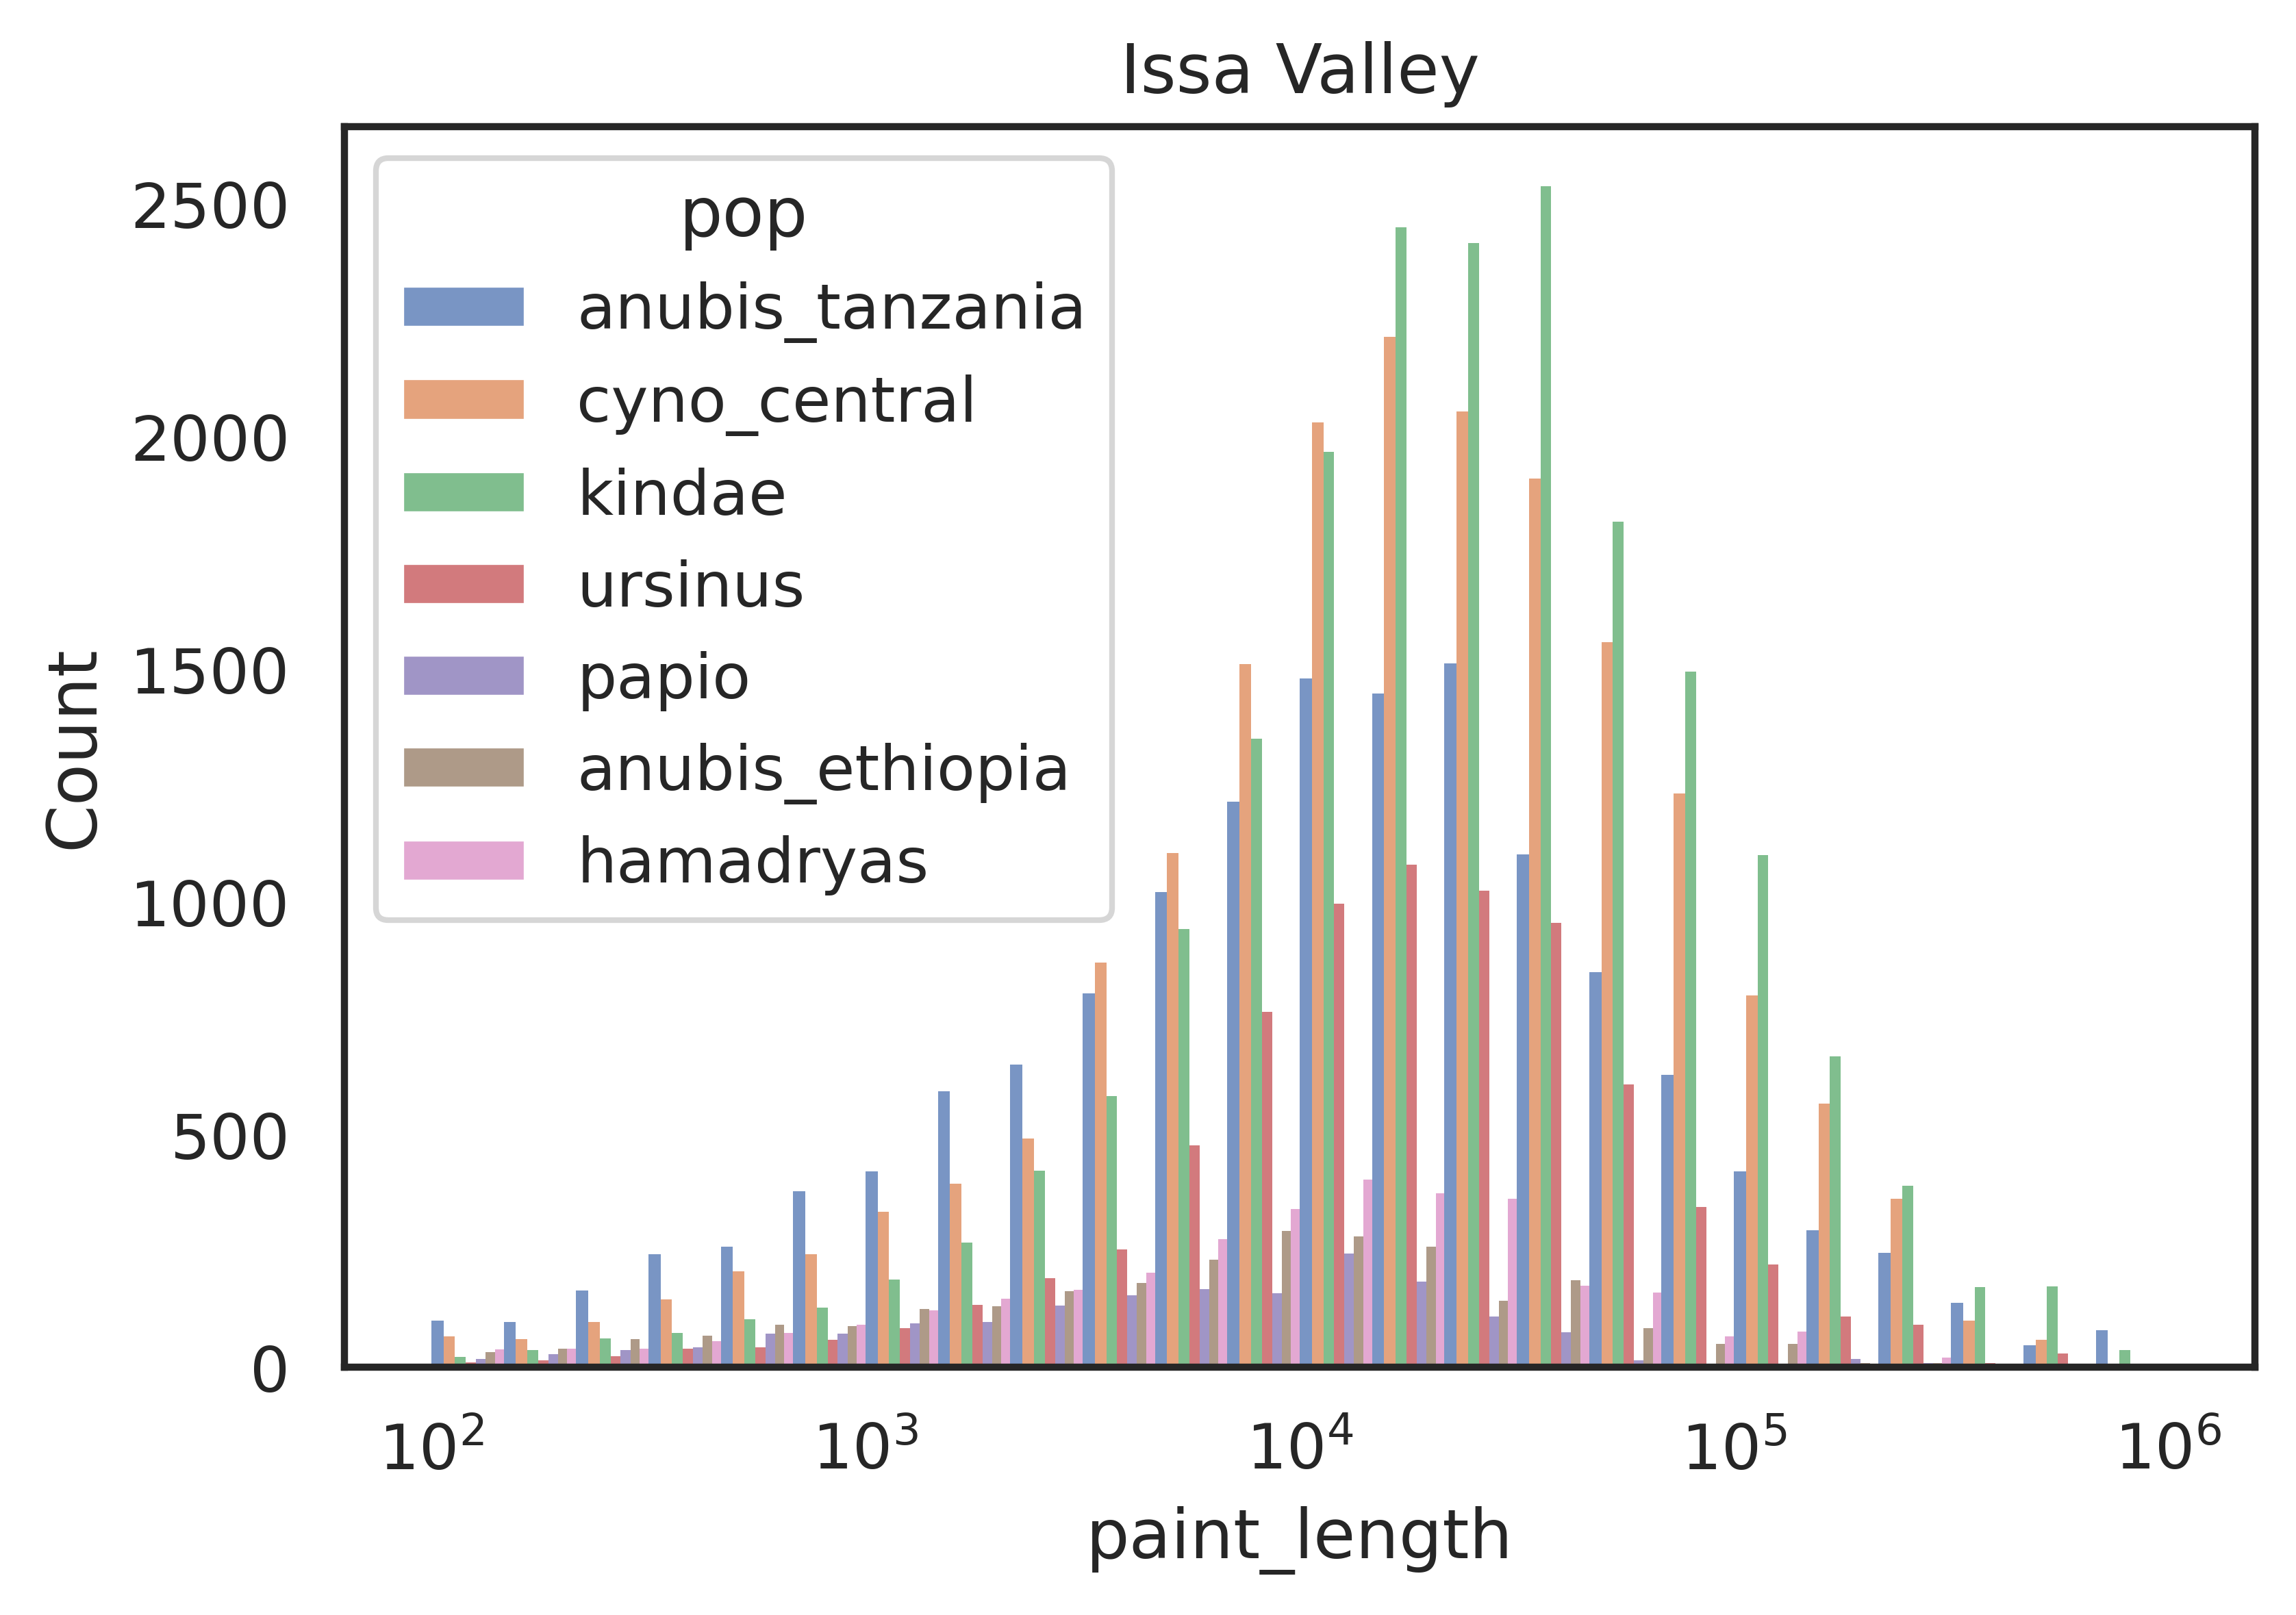

In [61]:
g = sns.histplot(length_df.loc[length_df.individual=="PD_0662"], x="paint_length", hue="pop", multiple="dodge",
                  bins=np.logspace(np.log10(100),np.log10(1000000), 25))
g.set(xscale="log", title="Issa Valley")

[None, Text(0.5, 1.0, 'The Other Yellows, West')]

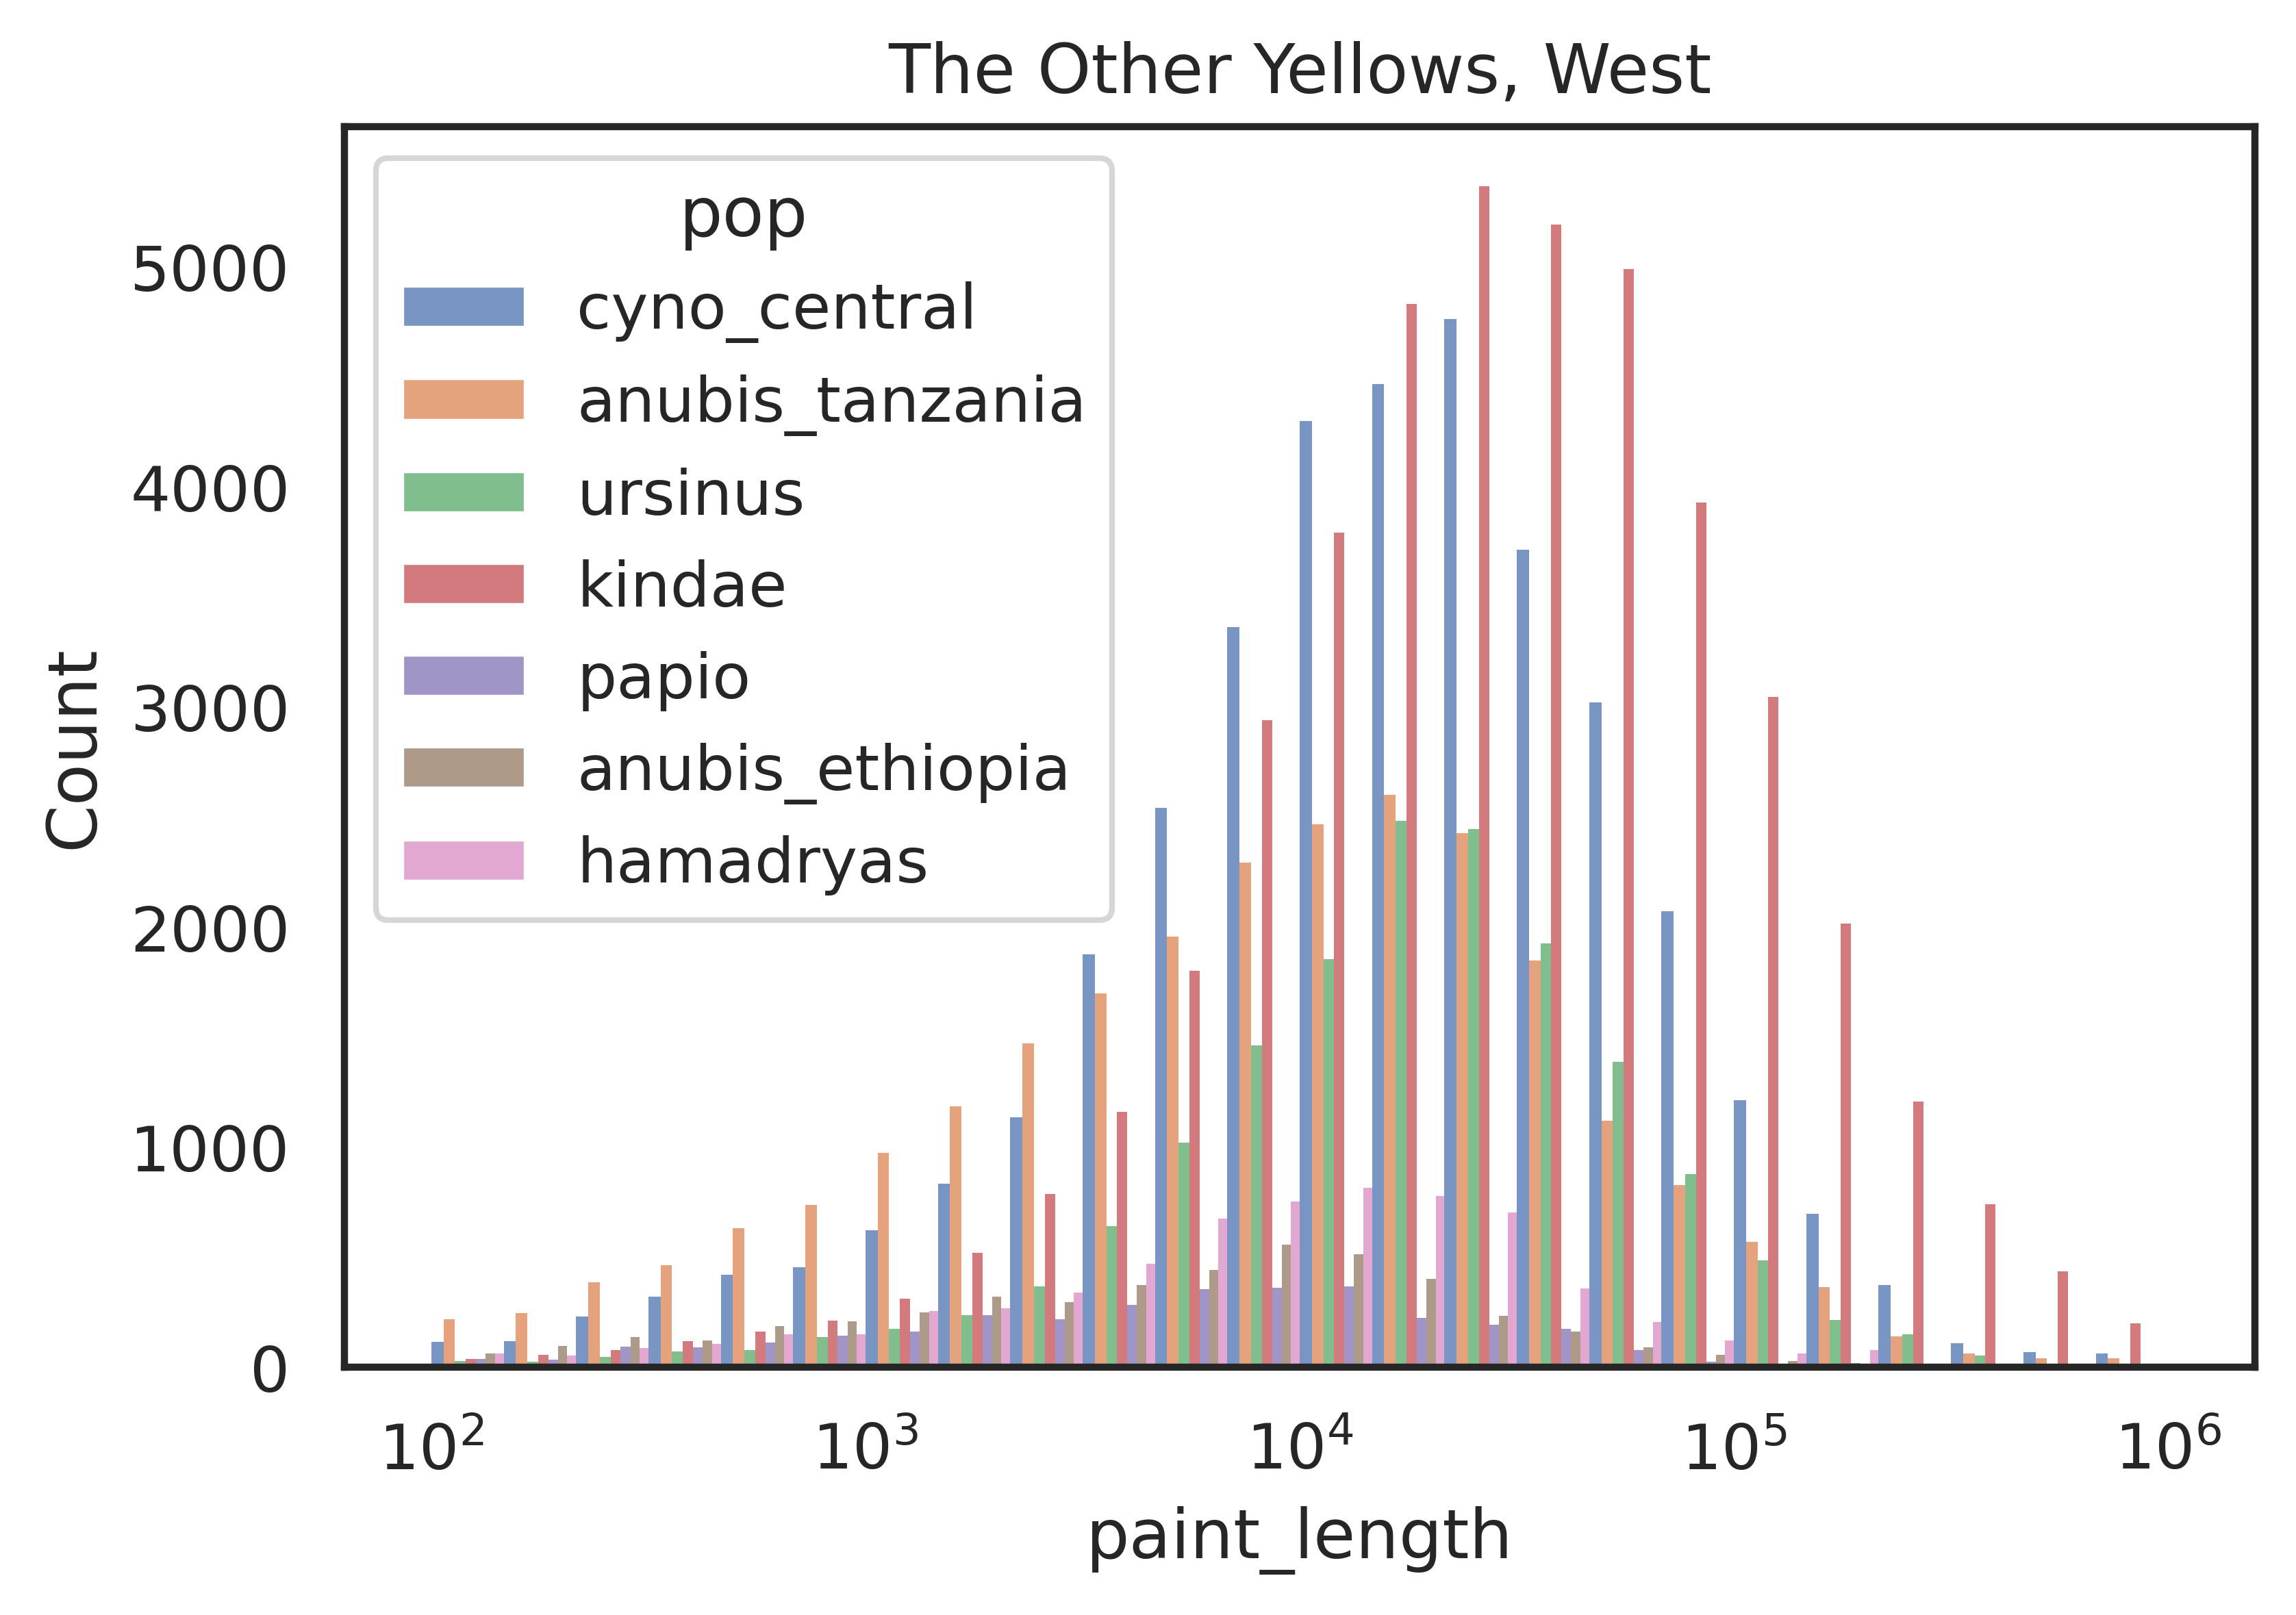

In [62]:
g = sns.histplot(length_df.loc[length_df.individual!="PD_0662"], x="paint_length", hue="pop", multiple="dodge",
                  bins=np.logspace(np.log10(100),np.log10(1000000), 25))
g.set(xscale="log", title="The Other Yellows, West")

In [67]:
window_df.loc[window_df.individual=="PD_0662"].sum()[:8]/window_df.loc[window_df.individual=="PD_0662"].sum()[:8].sum()

cyno_central         0.267927
kindae               0.373895
hamadryas           0.0224996
anubis_tanzania      0.224103
cyno_western                0
papio              0.00794417
ursinus             0.0884517
anubis_ethiopia     0.0151796
dtype: object

In [73]:
(0.267927+0.373895)/(0.232567+0.513956)

0.8597484605296823

In [68]:
window_df.loc[window_df.individual!="PD_0662"].sum()[:8]/window_df.loc[window_df.individual!="PD_0662"].sum()[:8].sum()

cyno_central         0.232567
kindae               0.513956
hamadryas           0.0197086
anubis_tanzania      0.124783
cyno_western                0
papio              0.00648788
ursinus             0.0927314
anubis_ethiopia    0.00976622
dtype: object

In [47]:
1577544191/paint_df.loc[paint_df.individual!="PD_0662"].sum()[:8].sum()

0.281006380260399

Various test calls

In [12]:
ursinus_chr9 = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/" \
                    "chr9_females_region/ursinuschr9_females_region/chr9.samples.out"
df_l = []
f = open(ursinus_chr9, "r")
ad_lines = f.readlines()

In [43]:
ad_lines[23][:100]

'EM_iter = 0 (N_e = 0 / copy_prop = 0 / mutation = 0 / mutationGLOBAL = 0), nsamples = 10, N_e_start '

In [23]:
len(ad_lines)

69

In [5]:
ursinus_chr18 = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/" \
                    "all_autosomes_fastrun/ursinusall_autosomes_fastrun/chr18.samples.out"
df_l = []
f = open(ursinus_chr18, "r")
chr18_lines = f.readlines()

In [21]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster_subset.ids"

In [22]:
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])

In [30]:
len(idfile), 227*2

(227, 454)

In [28]:
idfile.loc[idfile.inclusion==1].inclusion.index*2, idfile.loc[idfile.inclusion==1].inclusion.index*2+1

(Int64Index([  8,  22,  28,  36,  42,  68,  76,  78,  80,  82,  84,  86,  88,
              90, 106, 114, 118, 128, 132, 134, 136, 138, 140, 142, 146, 148,
             150, 162, 190, 194, 206, 208, 210, 216, 238, 240, 242, 248, 250,
             252, 254, 258, 264, 266, 268, 274, 276, 284, 296, 300, 302, 304,
             308, 312, 318, 324, 326, 328, 330, 334, 344, 356, 364, 366, 374,
             384, 394, 402, 416, 424, 434, 436, 438, 450],
            dtype='int64'),
 Int64Index([  9,  23,  29,  37,  43,  69,  77,  79,  81,  83,  85,  87,  89,
              91, 107, 115, 119, 129, 133, 135, 137, 139, 141, 143, 147, 149,
             151, 163, 191, 195, 207, 209, 211, 217, 239, 241, 243, 249, 251,
             253, 255, 259, 265, 267, 269, 275, 277, 285, 297, 301, 303, 305,
             309, 313, 319, 325, 327, 329, 331, 335, 345, 357, 365, 367, 375,
             385, 395, 403, 417, 425, 435, 437, 439, 451],
            dtype='int64'))

In [18]:
set(chr18_lines[11].split(" "))

{'10',
 '107',
 '108',
 '115',
 '116',
 '119',
 '120',
 '129',
 '130',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138',
 '139',
 '140',
 '141',
 '142',
 '143',
 '144',
 '147',
 '148',
 '149',
 '150',
 '151',
 '152',
 '163',
 '164',
 '191',
 '192',
 '195',
 '196',
 '207',
 '208',
 '209',
 '210',
 '211',
 '212',
 '217',
 '218',
 '23',
 '239',
 '24',
 '240',
 '241',
 '242',
 '243',
 '244',
 '259',
 '260',
 '265',
 '266',
 '267',
 '268',
 '269',
 '270',
 '275',
 '276',
 '277',
 '278',
 '285',
 '286',
 '29',
 '297',
 '298',
 '30',
 '301',
 '302',
 '303',
 '304',
 '305',
 '306',
 '309',
 '310',
 '313',
 '314',
 '319',
 '320',
 '325',
 '326',
 '327',
 '328',
 '329',
 '330',
 '331',
 '332',
 '335',
 '336',
 '345',
 '346',
 '357',
 '358',
 '365',
 '366',
 '367',
 '368',
 '37',
 '375',
 '375\n',
 '376',
 '38',
 '385',
 '386',
 '395',
 '396',
 '403',
 '404',
 '417',
 '418',
 '425',
 '426',
 '43',
 '435',
 '436',
 '437',
 '438',
 '439',
 '44',
 '440',
 '451',
 '452',
 '69',
 '70',
 '77',
 '78',
 '7

In [121]:
ad_lines[2][-100:]

'169 169 169 169 169 169 169 169 169 169 169 169 169 169 169 169 169 169 169 169 132 132 132 132 132\n'

In [122]:
example_lines[2][-100:]

'179 179 179 179 179 179 179 179 179 179 288 288 288 288 288 288 288 288 288 288 288 288 288 288 288\n'

In [109]:
ad_lines[67][:100]

'HAP 1 PD_0662\n'

In [45]:
np.unique(ad_lines[88].split(" "))

array(['10', '129', '130', '131', '132', '135', '136', '141', '142',
       '155', '156', '159', '160', '169', '17', '170', '171', '172', '18',
       '191', '192', '193', '194', '199', '200', '205', '206', '239',
       '240', '249', '250', '251', '252', '253', '254', '255', '256',
       '259', '260', '269', '270', '303', '304', '311', '312', '315',
       '316', '337', '338', '351', '352', '355', '356', '37', '379', '38',
       '380', '391', '392', '397', '398', '421', '422', '427', '428',
       '431', '432', '443', '444', '45', '46', '63', '64', '67', '68',
       '69', '70', '70\n', '73', '74', '77', '78'], dtype='<U3')